In [12]:
from typing import Annotated, List, TypedDict, Literal
from pydantic import BaseModel, Field
import operator
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from typing import Literal

from langchain_core.messages import HumanMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig

from langgraph.constants import Send
from langgraph.graph import START, END, StateGraph
from langgraph.types import interrupt, Command



import os
import asyncio
import requests

from tavily import TavilyClient, AsyncTavilyClient
from langsmith import traceable

from uuid import uuid4
from langgraph.checkpoint.memory import MemorySaver


## Prompts

In [3]:
DEFAULT_REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report"""



report_planner_query_writer_instructions="""You are an expert technical writer, helping to plan a report. 

<Report topic>
{topic}
</Report topic>

<Report organization>
{report_organization}
</Report organization>

<Task>
Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections. 

The queries should:

1. Be related to the topic of the report
2. Help satisfy the requirements specified in the report organization

Make the queries specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure.
</Task>
"""

report_planner_instructions="""I want a plan for a report. 

<Task>
Generate a list of sections for the report.

Each section should have the fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

For example, introduction and conclusion will not require research because they will distill information from other parts of the report.
</Task>

<Topic>
The topic of the report is:
{topic}
</Topic>

<Report organization>
The report should follow this organization: 
{report_organization}
</Report organization>

<Context>
Here is context to use to plan the sections of the report: 
{context}
</Context>

<Feedback>
Here is feedback on the report structure from review (if any):
{feedback}
</Feedback>
"""

In [4]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )



tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

async def tavily_search_async(search_queries):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process

    Returns:
            List[dict]: List of search responses from Tavily API, one per query. Each response has format:
                {
                    'query': str, # The original search query
                    'follow_up_questions': None,      
                    'answer': None,
                    'images': list,
                    'results': [                     # List of search results
                        {
                            'title': str,            # Title of the webpage
                            'url': str,              # URL of the result
                            'content': str,          # Summary/snippet of content
                            'score': float,          # Relevance score
                            'raw_content': str|None  # Full page content if available
                        },
                        ...
                    ]
                }
    """
    
    search_tasks = []
    for query in search_queries:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)
    return search_docs



def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes a list of search responses and formats them into a readable string.
    Limits the raw_content to approximately max_tokens_per_source.
 
    Args:
        search_responses: List of search response dicts, each containing:
            - query: str
            - results: List of dicts with fields:
                - title: str
                - url: str
                - content: str
                - score: float
                - raw_content: str|None
        max_tokens_per_source: int
        include_raw_content: bool
            
    Returns:
        str: Formatted string with deduplicated sources
    """
     # Collect all results
    sources_list = []
    for response in search_response:
        sources_list.extend(response['results'])
    
    # Deduplicate by URL
    unique_sources = {source['url']: source for source in sources_list}

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()


In [5]:

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )   

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )


    
class ReportState(TypedDict):
    topic: str # Report topic    
    feedback_on_report_plan: str # Feedback on the report plan
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report




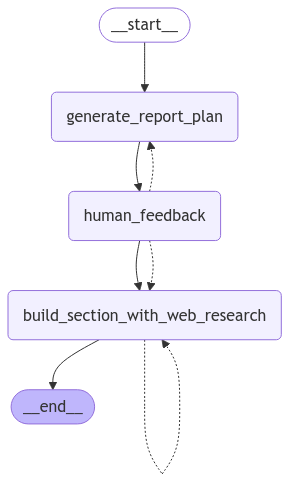

In [13]:
# Nodes
async def generate_report_plan(state: ReportState, config: RunnableConfig):
    """ Generate the report plan """

    print("==== Generating report plan ====")
    # Inputs
    topic = state["topic"]
    feedback = state.get("feedback_on_report_plan", None)

    # Get configuration
    report_structure = DEFAULT_REPORT_STRUCTURE
    number_of_queries = 2

    # Set writer model (model used for query writing and section writing)
    writer_model = ChatOpenAI(model="gpt-4o-mini",  temperature=0)
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)

    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+
                                    [HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Web search
    query_list = [query.search_query for query in results.queries]


    print("==== Searching the web ====")
    # Search the web
    search_results = await tavily_search_async(query_list)
    source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)

    print("==== Generating sections ====")
    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str, feedback=feedback)

    # Set the planner model
    planner_llm = ChatOpenAI(model="gpt-4o-mini",  temperature=0)
    
    # Generate sections 
    structured_llm = planner_llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections)]+
                                            [HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])

    # Get sections
    sections = report_sections.sections

    return {"sections": sections}




def human_feedback(state: ReportState) -> Command[Literal["generate_report_plan","build_section_with_web_research"]]:
    """ Get feedback on the report plan """

    # Get sections
    sections = state['sections']
    sections_str = "\n\n".join(
        f"Section: {section.name}\n"
        f"Description: {section.description}\n"
        f"Research needed: {'Yes' if section.research else 'No'}\n"
        for section in sections
    )

    # Get feedback on the report plan from interrupt

    feedback = interrupt(f"Please provide feedback on the following report plan. \n\n{sections_str}\n\n Does the report plan meet your needs? Pass 'true' to approve the report plan or provide feedback to regenerate the report plan:")

    # If the user approves the report plan, kick off section writing
    # if isinstance(feedback, bool) and feedback is True:
    if isinstance(feedback, bool):
        # Treat this as approve and kick off section writing
        return Command(goto=[
            Send("build_section_with_web_research", {"section": s, "search_iterations": 0}) 
            for s in sections 
            if s.research
        ])
    
    # If the user provides feedback, regenerate the report plan 
    elif isinstance(feedback, str):
        # treat this as feedback
        return Command(goto="generate_report_plan", 
                       update={"feedback_on_report_plan": feedback})
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")
    


def build_section_with_web_research(state: ReportState) -> Command[Literal["build_section_with_web_research"]]:
    """ Build a section with web research """

    # Get section
    print("==== Researching section ====")




builder = StateGraph(ReportState)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("human_feedback", human_feedback)
builder.add_node("build_section_with_web_research", build_section_with_web_research)


# Add edges
builder.add_edge(START, "generate_report_plan")
builder.add_edge("generate_report_plan", "human_feedback")
builder.add_edge("human_feedback", "build_section_with_web_research")
builder.add_edge("build_section_with_web_research", END)


memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
from IPython.display import Markdown

# Slow config, more in depth
thread = {"configurable": {"thread_id": str(uuid4())}}

topic = "The impact of AI on the future of work"
async for event in graph.astream({"topic":topic,}, thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

==== Generating report plan ====
==== Searching the web ====
==== Generating sections ====


Please provide feedback on the following report plan. 

Section: Introduction
Description: This section provides a brief overview of the impact of AI on the future of work, highlighting the significance of the topic and the key areas that will be explored in the report.
Research needed: No


Section: AI Job Market Trends
Description: This section discusses the current trends in the AI job market, including the emergence of new roles such as AI specialists and data scientists, and the growing demand for AI skills across various industries.
Research needed: Yes


Section: Opportunities and Challenges of AI in the Workplace
Description: This section explores the opportunities presented by AI, such as automation and efficiency gains, as well as the challenges it poses, including job displacement and the need for reskilling.
Research needed: Yes


Section: The Role of Reskilling and Upskilling
Description: This section focuses on the importance of reskilling and upskilling in an AI-driven job market, discussing the skills that will remain relevant and the need for continuous learning.
Research needed: Yes


Section: Human-AI Collaboration
Description: This section examines the concept of human-AI collaboration, highlighting the skills necessary for effective partnerships between humans and AI technologies in the workplace.
Research needed: Yes


Section: Future Job Projections and Skills Demand
Description: This section provides insights into future job projections related to AI, including the types of roles expected to emerge and the skills that will be in high demand.
Research needed: Yes


Section: Conclusion
Description: This section summarizes the key findings of the report, distilling the main points discussed in the body sections and providing a concise overview of the impact of AI on the future of work.
Research needed: No


 Does the report plan meet your needs? Pass 'true' to approve the report plan or provide feedback to regenerate the report plan:

In [15]:
# Pass feedback to update the report plan  
async for event in graph.astream(Command(resume="Include a section just to talk about OpenAI's development on AGI"), thread, stream_mode="updates"):
    if '__interrupt__' in event:
        interrupt_value = event['__interrupt__'][0].value
        display(Markdown(interrupt_value))

==== Generating report plan ====
==== Searching the web ====
==== Researching section ====
==== Generating sections ====


Please provide feedback on the following report plan. 

Section: Introduction
Description: This section provides a brief overview of the impact of AI on the future of work, setting the stage for the detailed analysis that follows.
Research needed: No


Section: AI Job Market Trends
Description: This section explores the current trends in the AI job market, including the emergence of new roles and the demand for AI-related skills as reported by various studies.
Research needed: Yes


Section: Opportunities and Challenges of AI in the Workplace
Description: This section discusses the opportunities presented by AI, such as automation and efficiency gains, as well as the challenges, including job displacement and the need for reskilling.
Research needed: Yes


Section: The Role of Human-AI Collaboration
Description: This section examines how AI is reshaping job roles through hybrid human-AI collaborations and the skills required to thrive in this new environment.
Research needed: Yes


Section: Skills for the Future Workforce
Description: This section identifies the key skills that will remain relevant in an AI-driven economy, emphasizing the importance of both technical and soft skills.
Research needed: Yes


Section: OpenAI and the Development of AGI
Description: This section focuses on OpenAI's advancements in artificial general intelligence (AGI) and its implications for the future of work and job markets.
Research needed: Yes


Section: Conclusion
Description: This section summarizes the key findings from the report, highlighting the main trends, opportunities, and skills needed for the future of work in an AI-driven world.
Research needed: No


 Does the report plan meet your needs? Pass 'true' to approve the report plan or provide feedback to regenerate the report plan: